In [1]:
import Pkg
Pkg.activate("../../Tasks2D/")
using Revise

  Activating project at `~/Developer/research/fall2023/cocosci/tasks2D/Tasks2D`


In [2]:
include("ipomdps.jl")

Precompiling GridWorlds
  ✓ GridWorlds
  1 dependency successfully precompiled in 5 seconds. 291 already precompiled.


Loaded in `pomdp` and `params`
Loaded in `inference_pomdp`
Beginning inference controller calibration...
Inference controller calibration completed.
Loaded in inference controllers:
  `adaptive_inference_controller`
  `c2f_fixed_ic_cheap` [1 particle; sigma_multiplier=1, coarsest_stepsize=0.4]
  `c2f_fixed_ic_expensive` [2 particle; sigma_multiplier=4, coarsest_stepsize=0.2]
  `bpf_ic` [10 particle bootstrap PF]


In [3]:
function get_onaction(ipomdp_trace)
    function onaction(a)
        (old_actions, params) = get_args(ipomdp_trace[])[2]
        T = (get_args(ipomdp_trace[]))[1] + 1
        is_windy = 50 < T
        ipomdp_trace[] = 
            Gen.update(
                ipomdp_trace[],
                (T, (actions=[old_actions..., a], params=params)),
                (UnknownChange(), NoChange()),
                GenPOMDPs.nest_choicemap(
                    choicemap((:state => :is_windy, is_windy)),
                    GenPOMDPs.state_addr(T)
                )
            )[1]
    end
end

get_onaction (generic function with 1 method)

In [4]:
using Dates
import Serialization
include("src/Utils.jl")
function save_ipomdp_trace(filename, itrace; metadata)
    Utils.serialize_trace_and_pf_states(
        filename, itrace,
        [st[end] for st in GenPOMDPs.controllerstate_sequence(itrace)];
        metadata
    )
end
function deserialize_ipomdp_trace(filename, rollout_model, pf_trajectory_model)
    s = Serialization.deserialize(filename)
    if haskey(s, "metadata")
        println("Loading trace using $rollout_model from save with metadata $(s["metadata"]).")
    end
    pf_states = [Utils.pf_state_from_serializable(pf_state, pf_trajectory_model) for pf_state in s["pf_states"]]
    itrace_args = s["trace"]["args"]
    params = itrace_args[end]
    params = (; params..., pf_states=pf_states)
    tr, _ = Gen.generate(rollout_model, (itrace_args[1:end-1]..., params), Utils.serializable_to_choicemap(s["trace"]["choices"]))
    return tr
end

function get_save_tr(tr_obs; metadata=Dict())
    function save_tr()
        filename = "saves/" * string(now()) * "__pomdp_trace.jld"
        save_ipomdp_trace(filename, tr_obs[]; metadata)
    end
    return save_tr
end


get_save_tr (generic function with 1 method)

In [5]:
using Makie, GLMakie

In [6]:
function get_did_hitwall_observable(trace)
    return map(trace -> GenPOMDPs.state_sequence(ipomdp_trace)[end].hit_wall, trace)
end


get_did_hitwall_observable (generic function with 1 method)

In [8]:
irollout_model = GenPOMDPs.RolloutModel(inference_pomdp, FixedC2FInferenceController(0.4, 0.2))

GenPOMDPs.var"##StaticGenFunction__RolloutModel#2546"(Dict{Symbol, Any}(), Dict{Symbol, Any}())

In [9]:
ipomdp_trace = Gen.simulate(irollout_model, (0, (actions=[], params=params)))
ipomdp_trace = Makie.Observable(ipomdp_trace)

Observable(GenPOMDPs.var"##StaticIRTrace__RolloutModel#2545"(0, (actions = Any[], params = (map = GridWorlds.FGridWorld(FunctionalCollections.PersistentVector{GridWorlds.GridCell}[[GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall], [GridWorlds.wall, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.wall], [GridWorlds.wall, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.wall], [GridWorlds.wall, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.wall], [GridWorlds.wall, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, 

In [44]:
get_pfstate(ipomdp_trace) = GenPOMDPs.controllerstate_sequence(ipomdp_trace)[end][end]

(f, t) = GridWorlds.Viz.interactive_2panel(
    get_onaction(ipomdp_trace),
    Makie.@lift(get_args($ipomdp_trace)[end].params.map), # map
    Makie.@lift([st.pos for st in GenPOMDPs.state_sequence($ipomdp_trace)]),
    Makie.@lift([
        [st.pos for st in GenPOMDPs.state_sequence(trace)]
        for trace in get_traces(get_pfstate($ipomdp_trace))
    ]),
    Makie.@lift(get_log_weights(get_pfstate($ipomdp_trace))),
    gt_obs=Makie.@lift(GenPOMDPs.observation_retval_sequence($ipomdp_trace)[end]),
    particle_obss=Makie.@lift([
        GenPOMDPs.observation_retval_sequence(trace)[end]
        for trace in get_traces(get_pfstate($ipomdp_trace))
    ]),
    close_on_hitwall=true,
    did_hitwall_observable=Makie.@lift(GenPOMDPs.state_sequence($ipomdp_trace)[end].hit_wall),
    save_fn = get_save_tr(ipomdp_trace; metadata=Dict("ic" => "Cheap fixed schedule c2f inference")),
)
display(f)

GLMakie.Screen(...)

Trace & pf states serialized to saves/2024-01-22T08:22:30.402__pomdp_trace.jld.


In [60]:
include("ipomdps.jl")

Loaded in `pomdp` and `params`
Loaded in `inference_pomdp`
Beginning inference controller calibration...
Inference controller calibration completed.
Loaded in inference controllers:
  `adaptive_inference_controller`
  `c2f_fixed_ic_cheap` [1 particle; sigma_multiplier=1, coarsest_stepsize=0.4]
  `c2f_fixed_ic_expensive` [2 particle; sigma_multiplier=4, coarsest_stepsize=0.2]
  `bpf_ic` [10 particle bootstrap PF]


In [64]:
filename = "saves/2024-01-22T08:22:30.402__pomdp_trace.jld"
ctm = GenPOMDPs.ControlledTrajectoryModel(pomdp)
ipomdp_trace2 = deserialize_ipomdp_trace(filename, irollout_model, ctm);

Loading trace using GenPOMDPs.var"##StaticGenFunction__RolloutModel#8114"(Dict{Symbol, Any}(), Dict{Symbol, Any}()) from save with metadata Dict("ic" => "adaptive inference controller").


(Δ = 0.5, σ_windy = 0.5, σ_normal = 0.05)

In [ ]:
let
    σ_windy = get_args(ipomdp_trace2)[end].params.step.σ_windy
    σ_normal = get_args(ipomdp_trace2)[end].params.step.σ_normal  
    _tr = ipomdp_trace2
    _pfstates = [st[end] for st in GenPOMDPs.controllerstate_sequence(_tr)]
    wind_level_strs = [
        "T=$t | Wind level: " * (st.is_windy ? "windy!" : "not windy")
        for (t, st) in enumerate(GenPOMDPs.state_sequence(_tr))
    ]
    gif_filename = GridWorlds.Viz.pf_result_gif(
        get_args(_tr)[end].params.map,
        fr -> [st.pos for st in GenPOMDPs.state_sequence(_tr)[1:fr]],
        fr -> [
            [st.pos for st in GenPOMDPs.state_sequence(trace)]
            for trace in get_traces(_pfstates[fr])
        ],
        fr -> get_log_weights(_pfstates[fr]);
        fr_to_gt_obs = fr -> GenPOMDPs.observation_retval_sequence(_tr)[fr],
        fr_to_particle_obss = fr -> [
            GenPOMDPs.observation_retval_sequence(trace)[end]
            for trace in get_traces(_pfstates[fr])
        ],
        framerate=4,
        n_frames=length(_pfstates)-1,
        n_panels=3,
        tail_length=8,
        labeltext="Inference via FixedC2FInferenceController(0.4, 0.2). σ_windy = $σ_windy; σ_normal = $σ_normal. fname = $(filename)",
        label_fontsize=16,
        big_label_text=(fr -> wind_level_strs[fr]),
        filename="10_success_then_fail",
        filetypes = ["gif", "mp4"],
    )
    println("File generated")
    display("image/gif", read(gif_filename))
end

In [28]:
function log_obs_likelihood(t, pfstate)
    vals = [Gen.project(tr, select(GenPOMDPs.obs_addr(t))) for tr in pfstate.traces]
    weights = GenParticleFilters.get_norm_weights(pfstate)
    return sum(weights .* vals)
end
vals = [log_obs_likelihood(t - 1, st[end]) for (t, st) in enumerate(GenPOMDPs.controllerstate_sequence(ipomdp_trace2))]

log_obs_likelihood (generic function with 1 method)

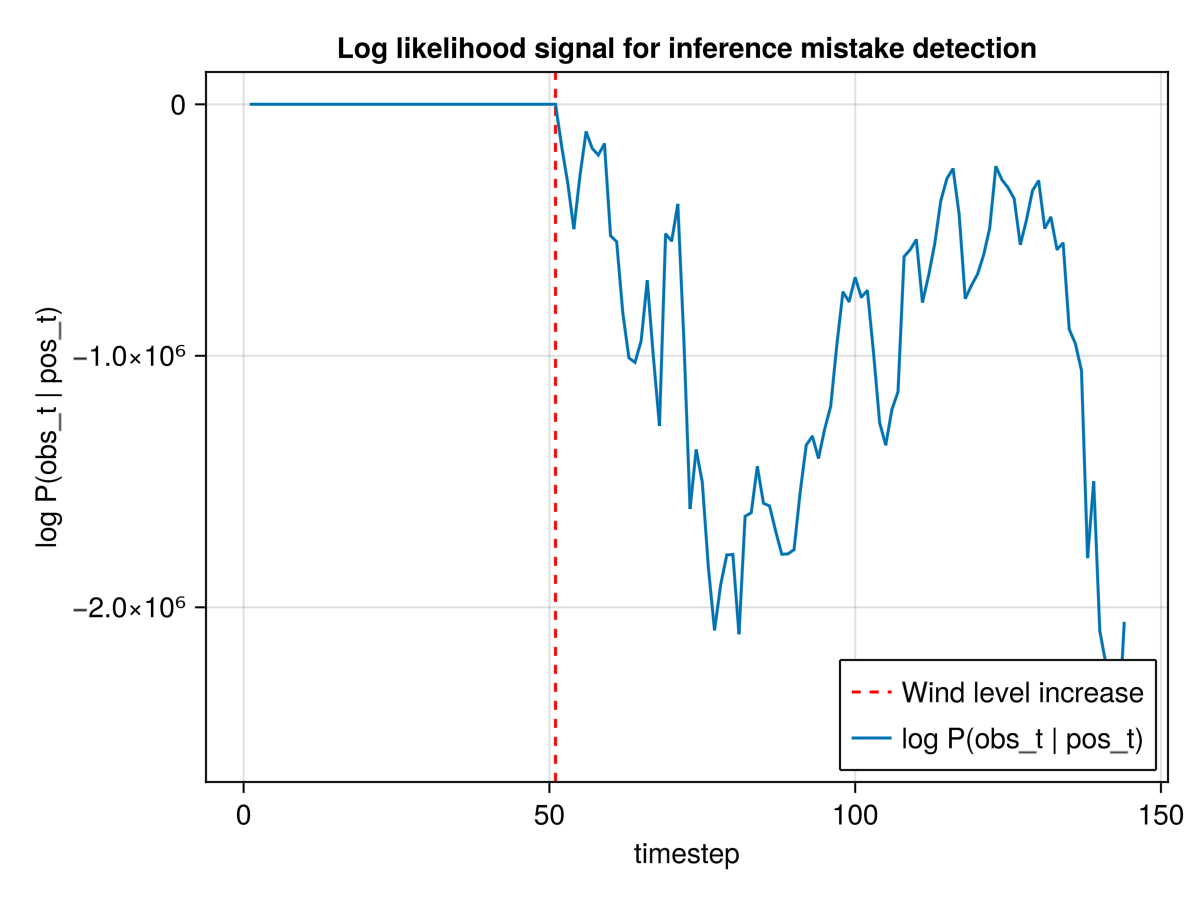

In [91]:
f = Makie.Figure(); ax = Makie.Axis(f[1, 1], xlabel="timestep", ylabel="log P(obs_t | pos_t)", title="Log likelihood signal for inference mistake detection")
Makie.vlines!(ax, [51], label="Wind level increase", color=:red, linestyle=:dash)
Makie.lines!(ax, vals, label="log P(obs_t | pos_t)")
# Makie.hlines!(ax, [threshold_1_in_10000], label="Mistake detection threshold", color=:orange)
Makie.axislegend(position=:rb)
f

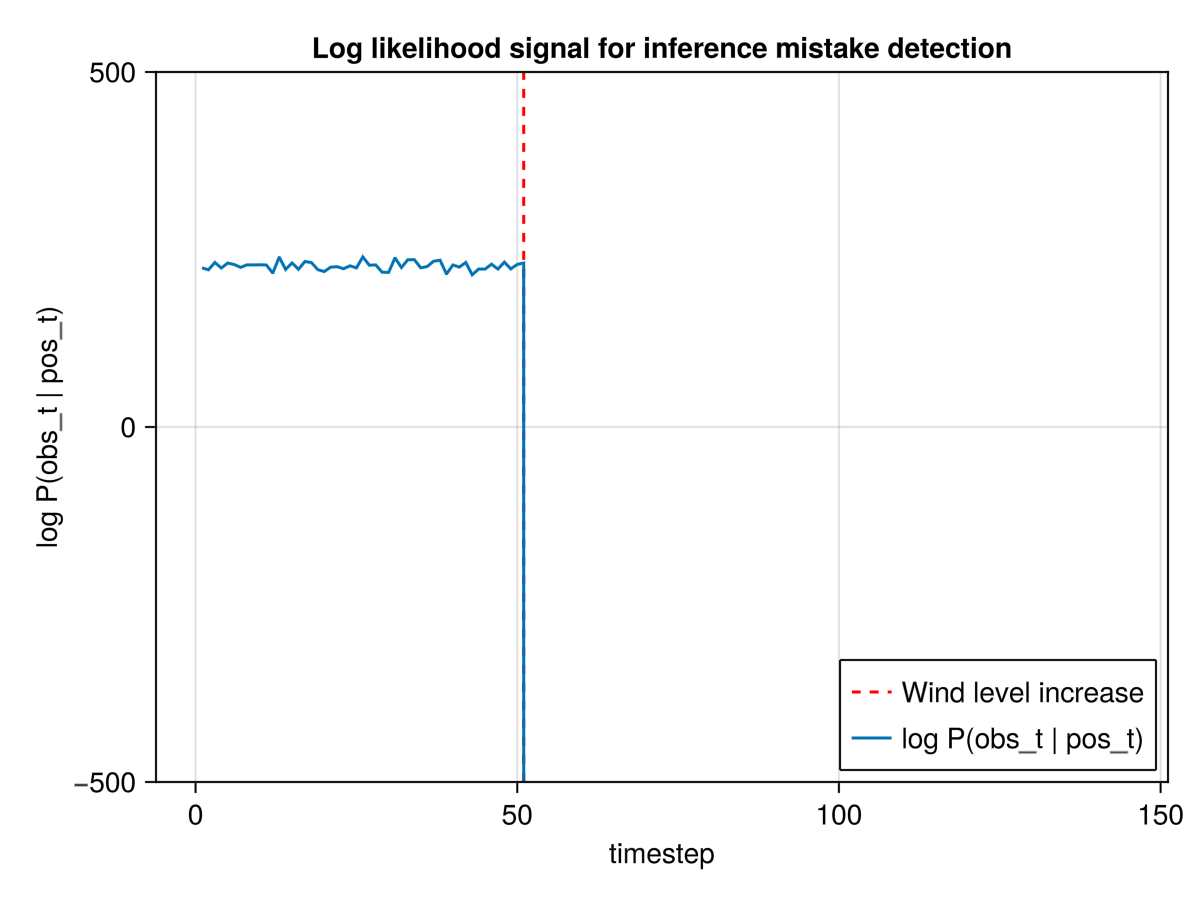

In [92]:
f = Makie.Figure(); ax = Makie.Axis(f[1, 1], xlabel="timestep", ylabel="log P(obs_t | pos_t)", title="Log likelihood signal for inference mistake detection")
Makie.vlines!(ax, [51], label="Wind level increase", color=:red, linestyle=:dash)
Makie.lines!(ax, vals, label="log P(obs_t | pos_t)")
# Makie.hlines!(ax, [threshold_1_in_10000], label="Mistake detection threshold", color=:orange)
Makie.axislegend(position=:rb)
Makie.ylims!(ax, (-500, 500))
f

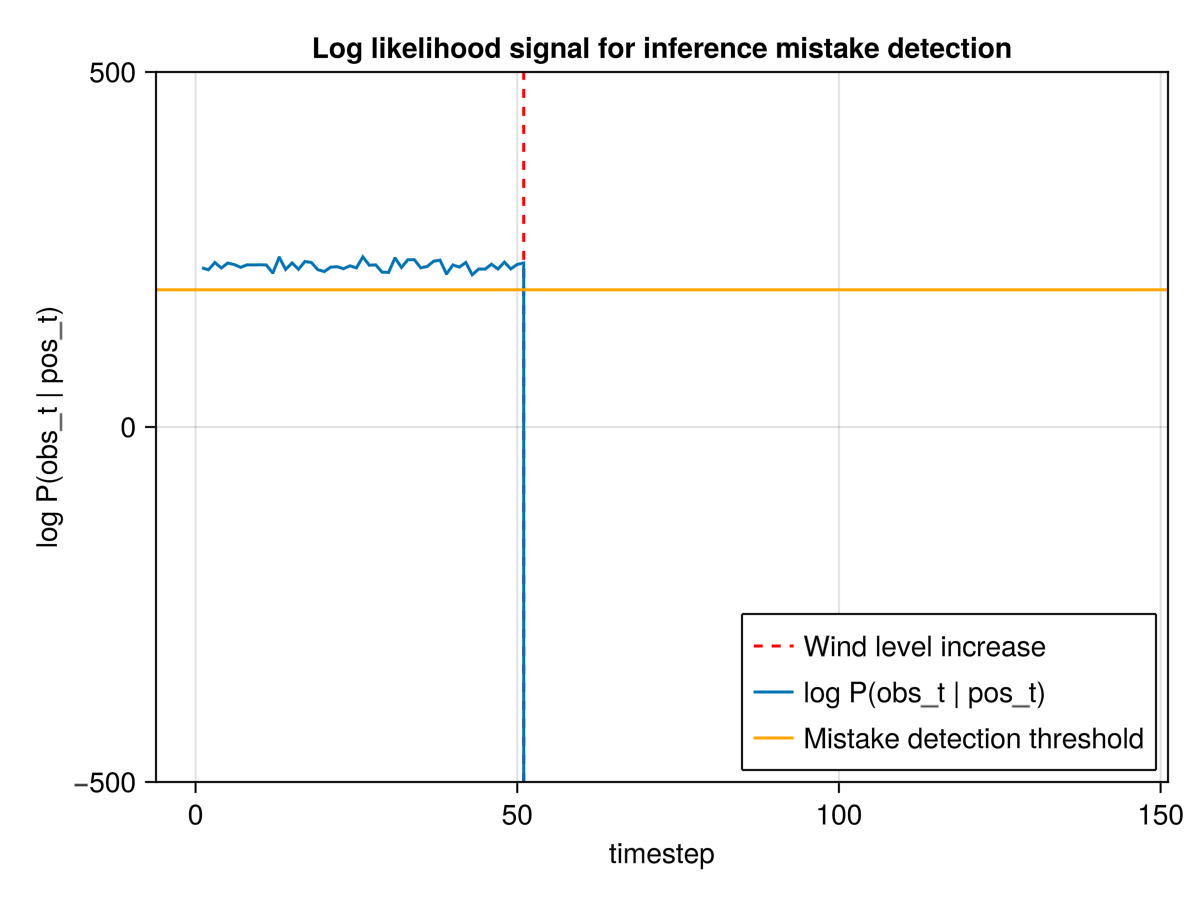

In [93]:
f = Makie.Figure(); ax = Makie.Axis(f[1, 1], xlabel="timestep", ylabel="log P(obs_t | pos_t)", title="Log likelihood signal for inference mistake detection")
Makie.vlines!(ax, [51], label="Wind level increase", color=:red, linestyle=:dash)
Makie.lines!(ax, vals, label="log P(obs_t | pos_t)")
Makie.hlines!(ax, [threshold_1_in_10000], label="Mistake detection threshold", color=:orange)
Makie.axislegend(position=:rb)
Makie.ylims!(ax, (-500, 500))
f

In [84]:
threshold_1_in_10000

193.30984333030557

## Run with AIC

In [22]:
irollout_model_aic = GenPOMDPs.RolloutModel(inference_pomdp, adaptive_inference_controller)

Loaded in `pomdp` and `params`
Loaded in `inference_pomdp`
Beginning inference controller calibration...
Inference controller calibration completed.
Loaded in inference controllers:
  `adaptive_inference_controller`
  `c2f_fixed_ic_cheap` [1 particle; sigma_multiplier=1, coarsest_stepsize=0.4]
  `c2f_fixed_ic_expensive` [2 particle; sigma_multiplier=4, coarsest_stepsize=0.2]
  `bpf_ic` [10 particle bootstrap PF]


GenPOMDPs.var"##StaticGenFunction__RolloutModel#9604"(Dict{Symbol, Any}(), Dict{Symbol, Any}())

In [23]:
get_pfstate(ipomdp_trace) = GenPOMDPs.controllerstate_sequence(ipomdp_trace)[end][end]

let 
    ipomdp_trace = Gen.simulate(irollout_model, (0, (actions=[], params=params)))
    ipomdp_trace = Makie.Observable(ipomdp_trace)
    (f, t) = GridWorlds.Viz.interactive_2panel(
        get_onaction(ipomdp_trace),
        Makie.@lift(get_args($ipomdp_trace)[end].params.map), # map
        Makie.@lift([st.pos for st in GenPOMDPs.state_sequence($ipomdp_trace)]),
        Makie.@lift([
            [st.pos for st in GenPOMDPs.state_sequence(trace)]
            for trace in get_traces(get_pfstate($ipomdp_trace))
        ]),
        Makie.@lift(get_log_weights(get_pfstate($ipomdp_trace))),
        gt_obs=Makie.@lift(GenPOMDPs.observation_retval_sequence($ipomdp_trace)[end]),
        particle_obss=Makie.@lift([
            GenPOMDPs.observation_retval_sequence(trace)[end]
            for trace in get_traces(get_pfstate($ipomdp_trace))
        ]),
        close_on_hitwall=true,
        did_hitwall_observable=Makie.@lift(GenPOMDPs.state_sequence($ipomdp_trace)[end].hit_wall),
        save_fn = get_save_tr(ipomdp_trace; metadata=Dict("ic" => "Adaptive inference controller")),
    )
    display(f) 
end

GLMakie.Screen(...)

In [ ]:
let
    filename = "saves/2024-01-22T10:18:04.449__pomdp_trace.jld"
    ctm = GenPOMDPs.ControlledTrajectoryModel(pomdp)
    ipomdp_trace2 = deserialize_ipomdp_trace(filename, irollout_model_aic, ctm);
    σ_windy = get_args(ipomdp_trace2)[end].params.step.σ_windy
    σ_normal = get_args(ipomdp_trace2)[end].params.step.σ_normal  
    _tr = ipomdp_trace2
    _pfstates = [st[end] for st in GenPOMDPs.controllerstate_sequence(_tr)]
    wind_level_strs = [
        "T=$t | Wind level: " * (st.is_windy ? "windy!" : "not windy")
        for (t, st) in enumerate(GenPOMDPs.state_sequence(_tr))
    ]
    gif_filename = GridWorlds.Viz.pf_result_gif(
        get_args(_tr)[end].params.map,
        fr -> [st.pos for st in GenPOMDPs.state_sequence(_tr)[1:fr]],
        fr -> [
            [st.pos for st in GenPOMDPs.state_sequence(trace)]
            for trace in get_traces(_pfstates[fr])
        ],
        fr -> get_log_weights(_pfstates[fr]);
        fr_to_gt_obs = fr -> GenPOMDPs.observation_retval_sequence(_tr)[fr],
        fr_to_particle_obss = fr -> [
            GenPOMDPs.observation_retval_sequence(trace)[end]
            for trace in get_traces(_pfstates[fr])
        ],
        framerate=4,
        n_frames=length(_pfstates)-1,
        n_panels=3,
        tail_length=8,
        labeltext="Inference via adaptive inference controller. σ_windy = $σ_windy; σ_normal = $σ_normal. fname = $(filename)",
        label_fontsize=16,
        big_label_text=(fr -> wind_level_strs[fr]),
        filename="11_success",
        filetypes = ["gif", "mp4"],
    )
    println("File generated")
    display("image/gif", read(gif_filename))
end

Loading trace using GenPOMDPs.var"##StaticGenFunction__RolloutModel#9604"(Dict{Symbol, Any}(), Dict{Symbol, Any}()) from save with metadata Dict("ic" => "Adaptive inference controller").


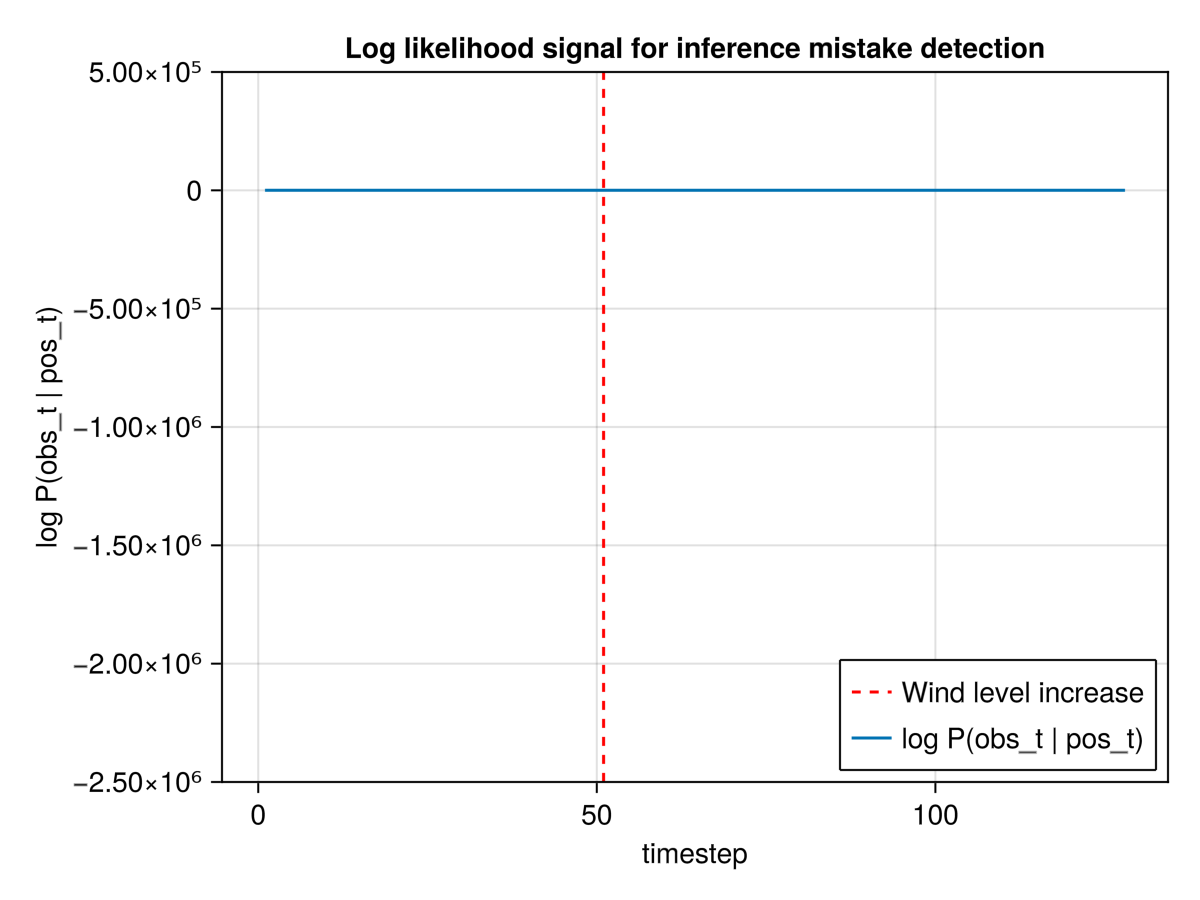

In [31]:

filename = "saves/2024-01-22T10:18:04.449__pomdp_trace.jld"
ctm = GenPOMDPs.ControlledTrajectoryModel(pomdp)
ipomdp_trace2 = deserialize_ipomdp_trace(filename, irollout_model_aic, ctm);
vals = [log_obs_likelihood(t - 1, st[end]) for (t, st) in enumerate(GenPOMDPs.controllerstate_sequence(ipomdp_trace2))]


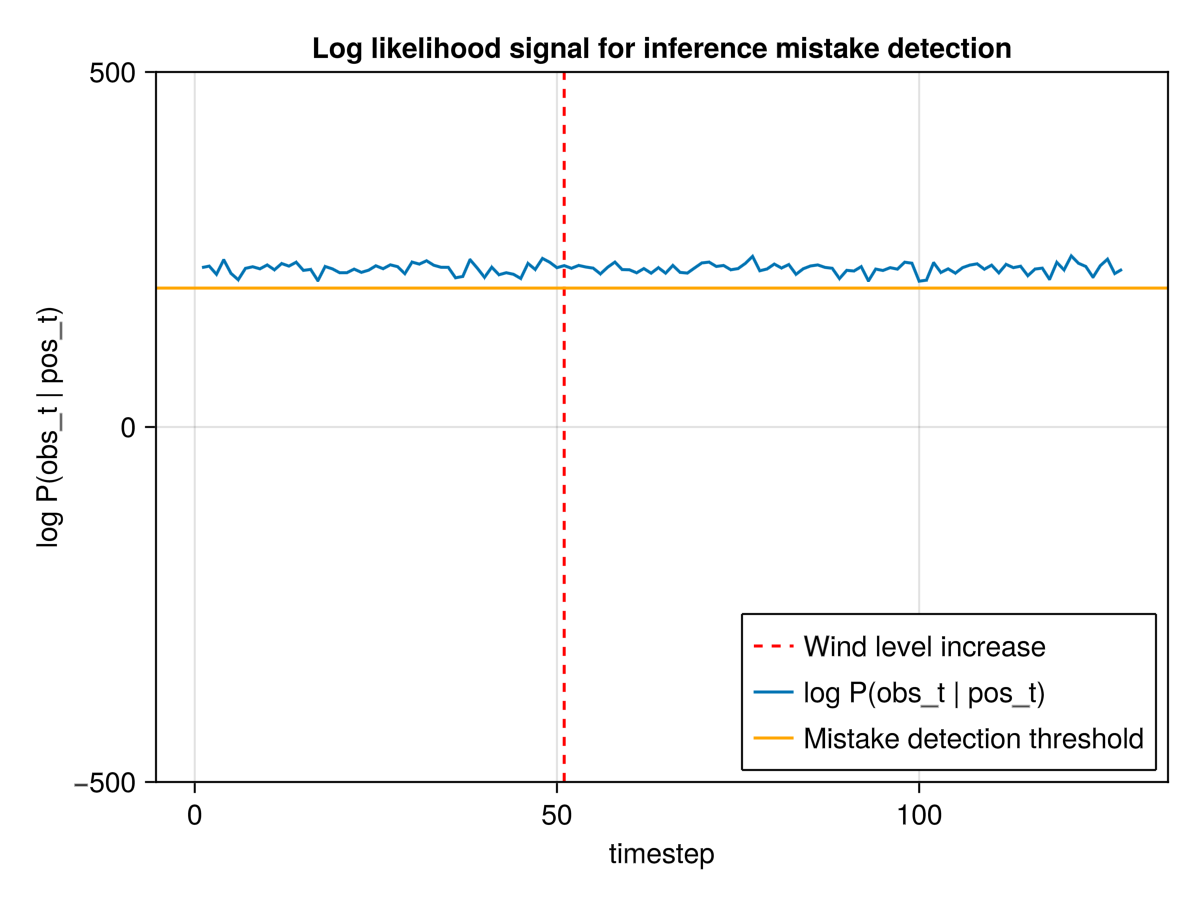

In [32]:
f = Makie.Figure(); ax = Makie.Axis(f[1, 1], xlabel="timestep", ylabel="log P(obs_t | pos_t)", title="Log likelihood signal for inference mistake detection")
Makie.vlines!(ax, [51], label="Wind level increase", color=:red, linestyle=:dash)
Makie.lines!(ax, vals, label="log P(obs_t | pos_t)")
Makie.hlines!(ax, [threshold_1_in_10000], label="Mistake detection threshold", color=:orange)
Makie.axislegend(position=:rb)
Makie.ylims!(ax, (-500, 500))
f